In [10]:
#SSOR
#Same method but with a forward and backwards SOR

import numpy as np
import scipy.sparse as sp

def spSORit(A,u,w,f):
    N = np.shape(u)[0]
    s0 = u[0]
    u[0] = ( f[0] - A[0,1:].dot(u[1:]) ) /A[0,0]  #First step manually
    u[0] = (1-w)*s0+w*u[0]
    for i in range(1,N-1): #Do N-2 steps automatically following algorithm
        s = u[i]
        u[i] = (f[i]-A[i,:i].dot(u[:i])-A[i,i+1:].dot(u[i+1:]))/A[i,i]
        u[i] = (1-w)*s+w*u[i]
    sN = u[-1] #Do last step manually
    u[-1] = (f[-1]-A[-1,:-1].dot(u[:-1]))/A[-1,-1]
    u[-1] = (1-w)*sN+w*u[-1]
    return u

def spSORBWit(A,u,w,f): 
    N = np.shape(u)[0]
    sN = u[-1] #Do last step manually
    u[-1] = (f[-1]-A[-1,:-1].dot(u[:-1]))/A[-1,-1]
    u[-1] = (1-w)*sN+w*u[-1]
    for i in reversed(range(1,N-1)): #Do N-2 steps automatically following algorithm but reversed
        s = u[i]
        u[i] = (f[i]-A[i,:i].dot(u[:i])-A[i,i+1:].dot(u[i+1:]))/A[i,i]
        u[i] = (1-w)*s+w*u[i]
    s0 = u[0]
    u[0] = (f[0] - A[0,1:].dot(u[1:]))/A[0,0]  #First step manually
    u[0] = (1-w)*s0+w*u[0]
    return u

#SSOR that runs N iterations
def spSSOR(A,u,w,f,N):
    u0 = u
    for i in range(N):
        u0 = SORit(A,u0,w,f)
        u0 = SORBWit(A,u0,w,f)
    return u0

#Define SSOR with stopping criteria on recidual vector / source vector (r/f)

def spSSORsc(A,u0,w,f,Stopping_criteria):  #A is csr_matrix while u0, f are dense np.array
    u = u0  #otherwise everything should be sparse
    r = A.dot(u) - f
    err = np.linalg.norm(r,2) / np.linalg.norm(f,2)
    it = 0  #To count number of iterations
    reduces_residuals = [err]
    while err > Stopping_criteria:
        it = it+1
        t = time.time()
        u = spSORit(A,u,w,f)
        print("time to run iteration: ",time.time()-t)
        u = spSORBWit(A,u,w,f)
        f_it = A.dot(u)
        r = f_it - f
        err = np.linalg.norm(r,2) / np.linalg.norm(f,2)
        reduces_residuals.append(err)
        #if it > 2000:
        #    print("Over", it ,"iterations. err is: ",err)
    print("number of iterations :", it)
    return u , np.array(reduces_residuals)



In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as la
import matplotlib.ticker as ticker

def sourcefunc_2D(x,y):
    f = (x**2 + y**2)*np.sin(x*y)
    return f

def boundary_2D(x,y):
    b = np.sin(x*y)
    return b

def sourcefunc_3D(x,y,z):
    f = ((y**2)*(x**2) + (y**2)*(z**2) + (z**2)*(x**2))*np.sin(x*y*z)
    return f

def boundary_3D(x,y,z):
    b = np.sin(x*y*z)
    return b


In [3]:
def create_Afuex_2D(sourcefunc_2D, boundary_2D, N):

    # Here I create the T_h and I_h matrices. These have precisely the same form as in the lecture notes. Some manual
    # stuff is done since we are working without elimination of boundary conditions
    h = 1/N
    N = int(N)
    Th = sp.diags([-1, 2, -1], [-1, 0, 1], shape=(N-1, N-1)).toarray()
    T_h = np.pad(Th,1)
    T_h[0,0] = h**2
    T_h[N,N] = h**2
    Ih = sp.diags([1],[0], shape=(N-1, N-1)).toarray()
    I_h = np.pad(Ih,1)
    # The final A_h matrix is construced here. Because of the h^2 * I_{N+1} identity matrix in the very top left 
    # corner and bottom right corner I have to change four values manually from zero to 1
    A_2D = (1/(h**2))*np.kron(T_h, I_h) + (1/(h**2))*np.kron(I_h, T_h)
    A_2D[0,0] = 1
    A_2D[N,N] = 1
    A_2D[(N+1)**2-N-1,(N+1)**2-N-1] = 1
    A_2D[(N+1)**2-1,(N+1)**2-1] = 1
    
    
    # A meshgrid is created here on which I will evalute the source function. This vector is the right size for
    # the final result, but it includes every boundary value also, as evaluated through f. This is obviously wrong
    # as these boundary values should be evaluated through b, so that has to be adjusted. I therefore immediately 
    # introduce b1 and b_end as vectors which are the boundary values on the bottom and top of the grid, respectively.
    # f is also reshaped here to be a vector, not an array.
    x,y = np.mgrid[0: 1: complex(0, N+1), 0: 1: complex(0, N+1)]
    x = x.transpose()
    y = y.transpose()

    f_2D = sourcefunc_2D(x,y)
    f_2D = np.reshape(f_2D, (N+1)*(N+1))

    x_axis = np.linspace(0, 1, num = N+1)
    b1 = boundary_2D(x_axis, 0)
    b_end = boundary_2D(x_axis, 1)
    
    # In this section I overwrite the parts of the f vector that represent boundary terms and next-to-boundary terms.
    # In the first loop I overwrite the first and last parts of f with b1 and b_end, so that the bottom and top of the 
    # 'grid' are boundary values. In the second loop I overwrite values representing the left and right side of the
    # 'grid'. Of course the bottom and left boundaries are just filled with zeros, as sin(xy) is zero when either x
    # or y is zero. In the third loop I overwrite the entries which represent positions next to the right boundary. In
    # the last loop I overwrite the entries which represent positions right below the top boundary. 


    for i in range(0, N+1):
        f_2D[i] = b1[i]
        f_2D[(N+1)*N + i] = b_end[i]

    for i in range(1,N):
        f_2D[i*(N+1)] = 0
        f_2D[i*(N+1)+ N] = boundary_2D(1, i*h)
    
    for i in range(0,N-1):    
        f_2D[2*N+i*(N+1)] = f_2D[2*N+i*(N+1)] + boundary_2D(1, (i+1)*h)/(h**2)
    
    for i in range(0,N-1):     
        f_2D[(N+1)**2-1-2*N+i] = f_2D[(N+1)**2-1-2*N+i] + b_end[i+1]/(h**2)
        
    u_ex_pre_2D = boundary_2D(x,y)
    u_ex_2D = np.reshape(u_ex_pre_2D, (1, (N+1)*(N+1)))
    
    
    A_2D = sp.csc_matrix(A_2D)

    return A_2D , f_2D , u_ex_2D



In [11]:
#Create array of A,f 's

#Create A,f,u_ex for various sizes 2D #Data[p] = [A(p),f(p),u_ex(p)]
data_2D = []
N_array_2D = [8,16]
for N in N_array_2D:
    A_2D , f_2D, u_ex_2D = create_Afuex_2D(sourcefunc_2D, boundary_2D, N)
    data_2D.append((A_2D,f_2D,u_ex_2D))

In [12]:
import time
time_array_2D = []

for i in range(np.size(N_array_2D)):
    A = data_2D[i][0]
    f = data_2D[i][1]
    u0 = np.zeros(np.shape(f)[0])
    w = 1.5 #omega

    t = time.time()
    u , res = spSSORsc(A,u0,w,f,10E-10)
    t = time.time()-t 
    time_array_2D.append(t)

time to run iteration:  0.02141594886779785
time to run iteration:  0.024202823638916016
time to run iteration:  0.02470684051513672
time to run iteration:  0.015100955963134766
time to run iteration:  0.015323162078857422
time to run iteration:  0.015302896499633789
time to run iteration:  0.01526188850402832
time to run iteration:  0.014976024627685547
time to run iteration:  0.015072107315063477
time to run iteration:  0.018173933029174805
time to run iteration:  0.016078710556030273
time to run iteration:  0.015137910842895508
time to run iteration:  0.01640486717224121
time to run iteration:  0.017488718032836914
time to run iteration:  0.01721501350402832
time to run iteration:  0.015604019165039062
time to run iteration:  0.0166318416595459
time to run iteration:  0.016314983367919922
time to run iteration:  0.01800394058227539
time to run iteration:  0.016449928283691406
time to run iteration:  0.015456199645996094
time to run iteration:  0.01548910140991211
time to run iterati

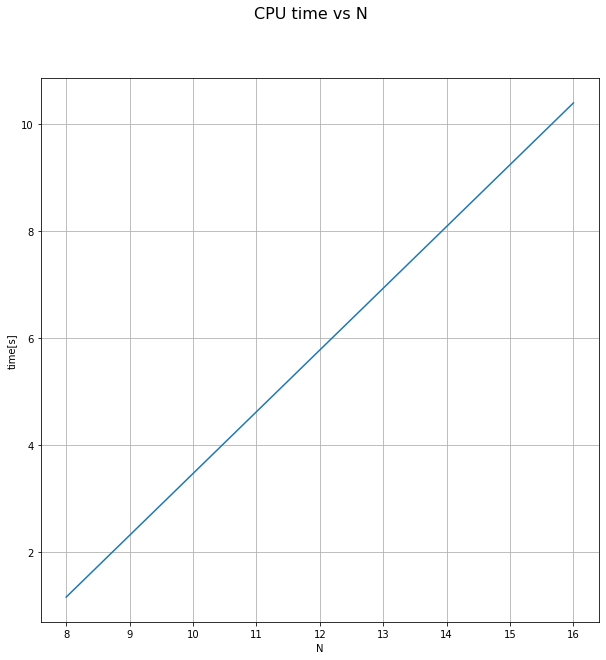

In [13]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, figsize=(10, 10))  #Creating the plots
fig.suptitle("CPU time vs N", fontsize=16)

ax.plot(N_array_2D,time_array_2D)
ax.set(xlabel = "N", ylabel = "time[s]")  #Labels and title
#ax.set_yscale('log')
ax.grid(True)